# Let's try to fit the borehole temperature data in ALHIC1902

/home/bpl7/.conda/envs/python3.11-obspy/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/home/bpl7/.conda/envs/python3.11-obspy/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


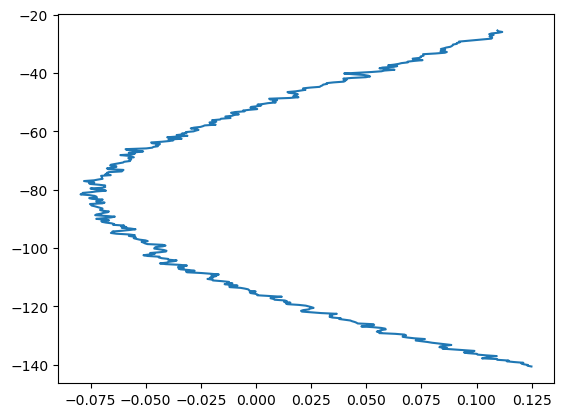

In [1]:
from heat import heat


import matplotlib.pyplot as plt
import pickle
import xarray as xr
from scipy.signal import filtfilt, butter, detrend
import numpy as np

filepath = '/data/fast1/jm-scratch/data_proc.pkl'

with open(filepath,'rb') as file:
    data = pickle.load(file)
    
borehole = data['ALHIC1902_23_5min']

z_data = np.array(borehole[0])
T_data = borehole[1].values

zmax = 554
zmin = 100
offset_trace = np.mean(T_data[zmin:zmax,:],axis=1)
plt.plot(detrend(offset_trace),-z_data[zmin:zmax])

Text(0.5, 1.0, 'Standard deviation of noise 3.10 mK')

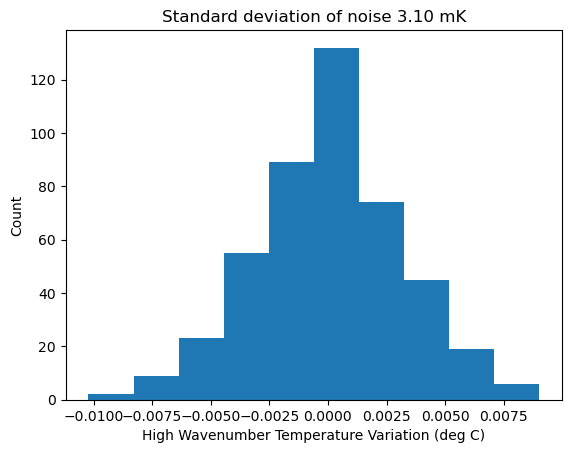

In [56]:
b,a=butter(2,0.02,'high')
hfnoise = filtfilt(b,a,detrend(offset_trace))
plt.hist(hfnoise)
data_std=np.std(hfnoise)
plt.xlabel('High Wavenumber Temperature Variation (deg C)')
plt.ylabel('Count')
plt.title(f'Standard deviation of noise {1000*data_std:.2f} mK')

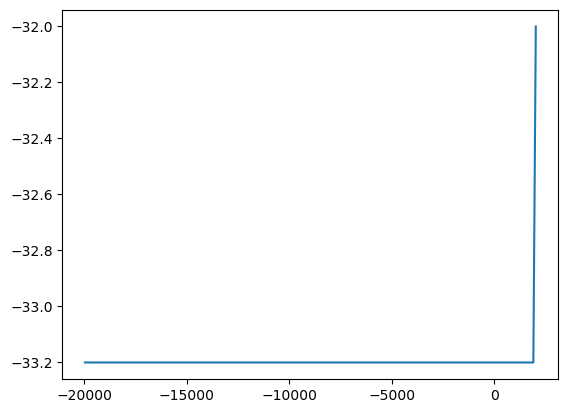

In [65]:
start_year = -20000+23
end_year = 2023
number_of_time_steps = (end_year-start_year)//10 - 1
max_depth = 140
nz = 159

# Make a vector of times (units are in decimal years)
t = np.linspace(start_year,end_year, number_of_time_steps+1)

# Force the temperature at the surface to follow a sinusoidal pattern corresponding to an annual fluctuation, 
# plus a mean annual background temperature
mean_annual_T = -32.0

# seasonal_dT = 40
# t_surf= mean_annual_T* np.ones(number_of_time_steps+1)\
#         + seasonal_dT*np.sin(np.pi*2*t)\
#         + (t-t[0]) * 0.01

t_surf= mean_annual_T* np.ones(number_of_time_steps+1)\
        + (t-t[-1]) * 0.01
t1900 = np.argmin(np.abs(t-1900))
t_surf[t<1900] = t_surf[t1900]

U,t,z = heat(t_surf,tmax=end_year,tmin=start_year,
             nt=number_of_time_steps,
             zmax=max_depth,nz=nz,
             accumulation=-0.01,
             dTdz = 0.026)

plt.plot(t,t_surf)

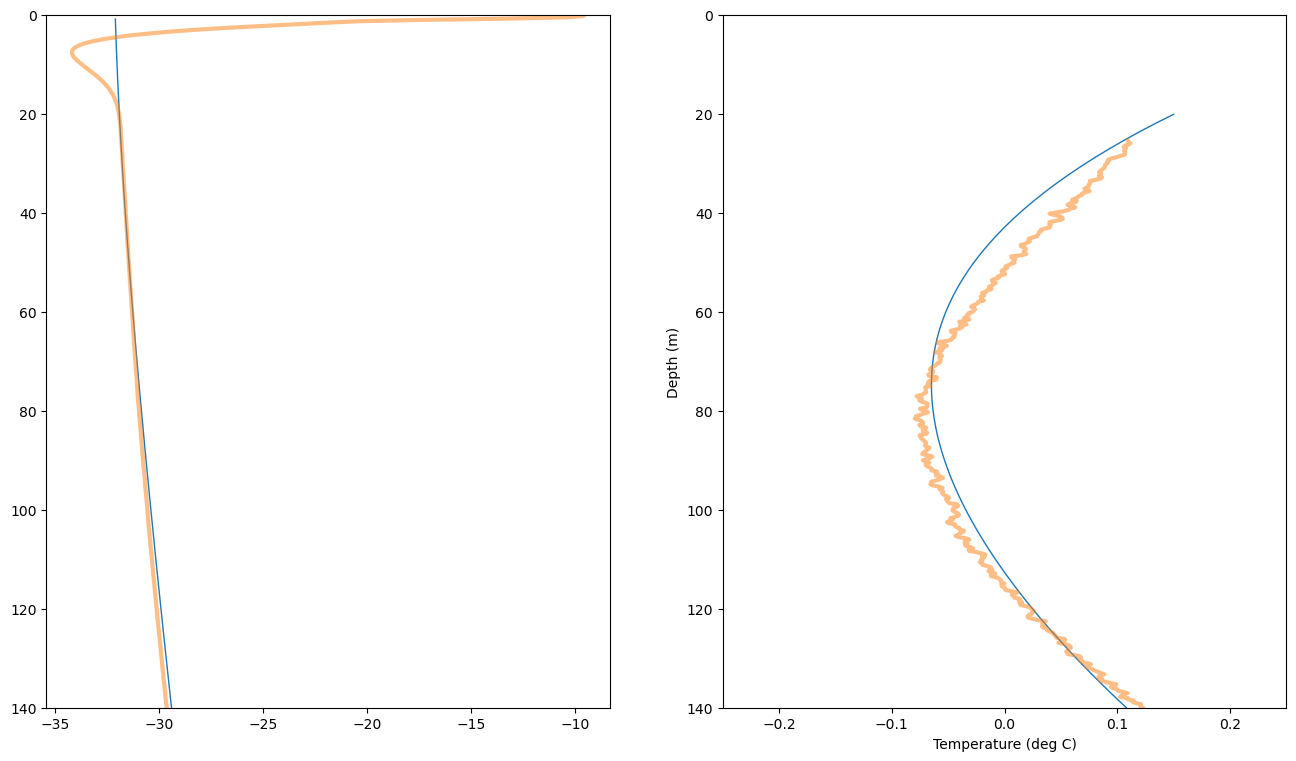

In [3]:
from scipy.signal import detrend
fig,ax=plt.subplots(1,2,figsize=(16,9))

plot_detrend=0

for plot_detrend in (0,1):
    if plot_detrend:
#         for i in range(1,16):
#             ax[plot_detrend].plot(detrend(U[:,-i]),z,c='lightgrey')
        z_min_model=20
        ax[plot_detrend].plot(detrend(U[:,-1][z>z_min_model]),z[z>z_min_model],label=f'Fall',linewidth=1)
#         ax[plot_detrend].plot(detrend(U[:,-5][z>z_min_model]),z[z>z_min_model],label=f'Summer',linewidth=1)
#         ax[plot_detrend].plot(detrend(U[:,-9][z>z_min_model]),z[z>z_min_model],label=f'Spring',linewidth=1)
#         ax[plot_detrend].plot(detrend(U[:,-13][z>z_min_model]),z[z>z_min_model],label=f'Winter',linewidth=1)
        
        zmax = 554
        zmin = 100
        offset_trace = np.mean(T_data[zmin:zmax,:],axis=1)
        
        ax[plot_detrend].plot(detrend(offset_trace),z_data[zmin:zmax],linewidth=3,alpha=0.5)
        ax[plot_detrend].set_xlim([-0.25,0.25])
    else:
#         for i in range(1,16):
#             ax[plot_detrend].plot((U[:,-i]),z,c='lightgrey')
        ax[plot_detrend].plot((U[:,-1]),z,label=f'Fall',linewidth=1)
#         ax[plot_detrend].plot((U[:,-5]),z,label=f'Summer',linewidth=1)
#         ax[plot_detrend].plot((U[:,-9]),z,label=f'Spring',linewidth=1)
#         ax[plot_detrend].plot((U[:,-13]),z,label=f'Winter',linewidth=1)
        
        zmax = 554
        zmin = 0
        offset_trace = np.mean(T_data[zmin:zmax,:],axis=1)
        ax[plot_detrend].plot((offset_trace),z_data[zmin:zmax],linewidth=3,alpha=0.5)
#         ax[plot_detrend].set_xlim([-35,-25])
        
    ax[plot_detrend].set_ylim([max_depth,0])

# plt.legend()
plt.ylabel('Depth (m)')

plt.xlabel('Temperature (deg C)')
plt.show()

# How far back in time do we have sensitivity?

In [16]:
# run a longer simulation that has a bump 500 years ago
t_surf2 = np.copy(t_surf)
t5000 = np.argmin(np.abs(t+5000))
t10000 = np.argmin(np.abs(t+10000))
t_surf2[t10000:t5000] -= 1

U2,t2,z2 = heat(t_surf2,tmax=end_year,tmin=start_year,
             nt=number_of_time_steps,
             zmax=max_depth,nz=nz,
             accumulation=-0.01,
             dTdz = 0.026)

In [8]:
# run a longer simulation that has a bump 500 years ago
t_surf3 = np.copy(t_surf)
t1000 = np.argmin(np.abs(t-1000))
t1500 = np.argmin(np.abs(t-1500))
t_surf3[t1000:t1500] -= 1

U3,t3,z3 = heat(t_surf3,tmax=end_year,tmin=start_year,
             nt=number_of_time_steps,
             zmax=max_depth,nz=nz,
             accumulation=-0.01,
             dTdz = 0.026)

In [9]:
# run a longer simulation that has a bump 5000+ years ago
t_surf4 = np.copy(t_surf)
t15000 = np.argmin(np.abs(t+15000))
t_surf4[0:t15000] -= 10

U4,t4,z4 = heat(t_surf4,tmax=end_year,tmin=start_year,
             nt=number_of_time_steps,
             zmax=max_depth,nz=nz,
             accumulation=-0.01,
             dTdz = 0.026)

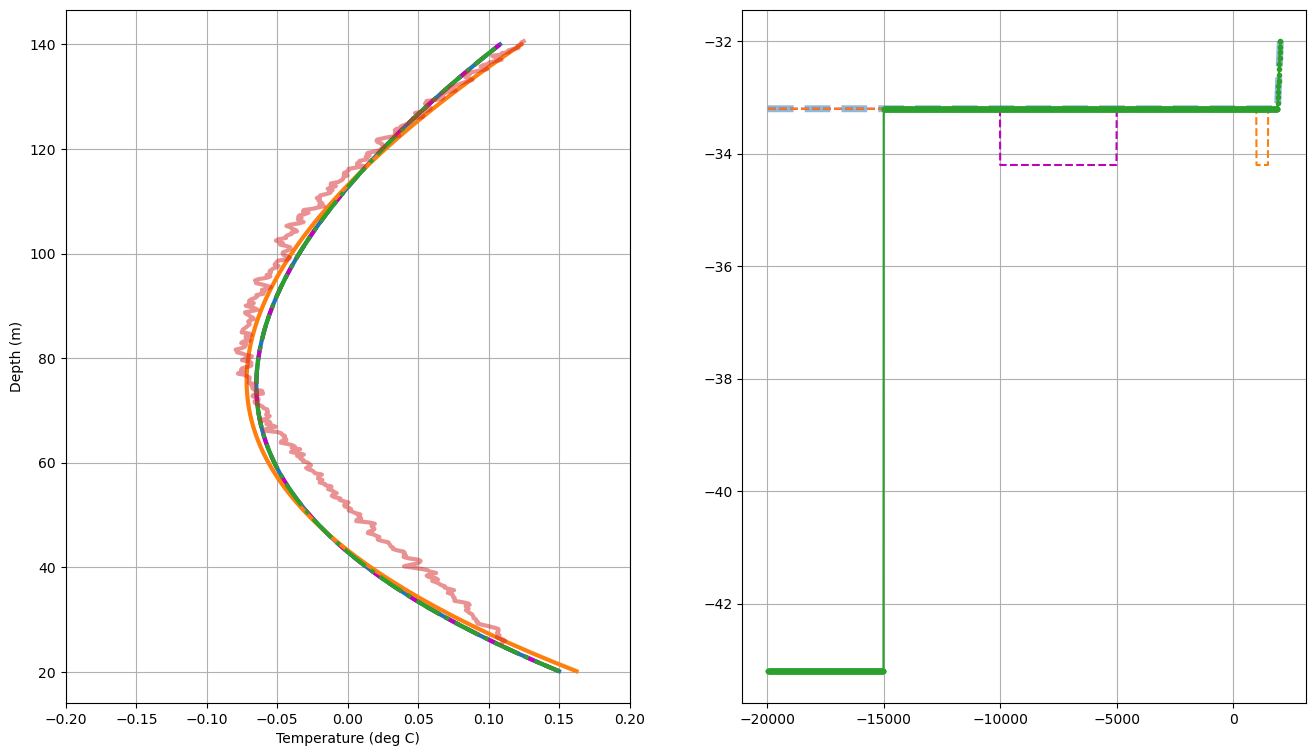

In [30]:
fig,ax=plt.subplots(1,2,figsize=(16,9))

z_min_model=20
ax[0].plot(detrend(U[:,-1][z>z_min_model]),z[z>z_min_model],'-',linewidth=3)
ax[0].plot(detrend(U2[:,-1][z2>z_min_model]),z2[z2>z_min_model],'--m',linewidth=3)
ax[0].plot(detrend(U3[:,-1][z3>z_min_model]),z3[z3>z_min_model],linewidth=3)
ax[0].plot(detrend(U4[:,-1][z4>z_min_model]),z4[z3>z_min_model],'-.',linewidth=3)

zmax = 554
zmin = 100
offset_trace = np.mean(T_data[zmin:zmax,:],axis=1)

ax[0].plot(detrend(offset_trace),z_data[zmin:zmax],linewidth=3,alpha=0.5)
ax[0].set_xlim([-0.2,0.2])

ax[0].set_ylabel('Depth (m)')
ax[0].grid()
ax[0].set_xlabel('Temperature (deg C)')


ax[1].plot(t,t_surf,linewidth=5,alpha=0.5,linestyle='--')
ax[1].plot(t2,t_surf2,'--m')
ax[1].plot(t3,t_surf3,'--')
ax[1].plot(t4,t_surf4,'.-')

ax[1].grid()

plt.show()

Text(0, 0.5, 'Depth (m)')

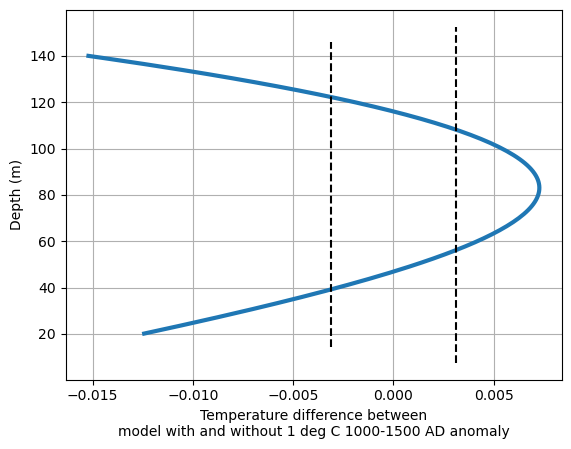

In [62]:
plt.plot(detrend(U[:,-1][z>z_min_model]) - detrend(U3[:,-1][z>z_min_model]),z[z>z_min_model],'-',linewidth=3)
plt.xlabel('Temperature difference between\nmodel with and without 1 deg C 1000-1500 AD anomaly')
plt.grid()
plt.plot(-data_std*np.array([1, 1]),plt.ylim(),'--k')
plt.plot(+data_std*np.array([1, 1]),plt.ylim(),'--k')
plt.ylabel('Depth (m)')

# How deep does the seasonal cycle penetrate?

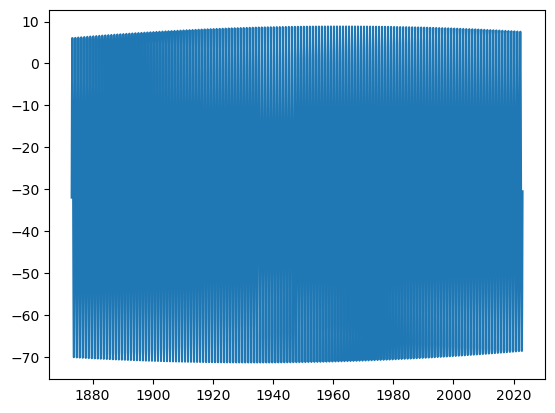

In [64]:
start_year = 1873
end_year = 2023
number_of_time_steps = (end_year-start_year)*10 - 1
max_depth = 140
nz = 159

# Make a vector of times (units are in decimal years)
t = np.linspace(start_year,end_year, number_of_time_steps+1)

# Force the temperature at the surface to follow a sinusoidal pattern corresponding to an annual fluctuation, 
# plus a mean annual background temperature
mean_annual_T = -32.0

seasonal_dT = 40
t_surf= mean_annual_T* np.ones(number_of_time_steps+1)\
        + seasonal_dT*np.sin(np.pi*2*t)\
        + (t-t[0]) * 0.01

# t_surf= mean_annual_T* np.ones(number_of_time_steps+1)\
#         + (t-t[-1]) * 0.01

# t1900 = np.argmin(np.abs(t-1900))
# t_surf[t<1900] = t_surf[t1900]

U_seasonal,t_seasonal,z_seasonal = heat(t_surf,tmax=end_year,tmin=start_year,
             nt=number_of_time_steps,
             zmax=max_depth,nz=nz,
             accumulation=-0.01,
             dTdz = 0.026)

plt.plot(t,t_surf)

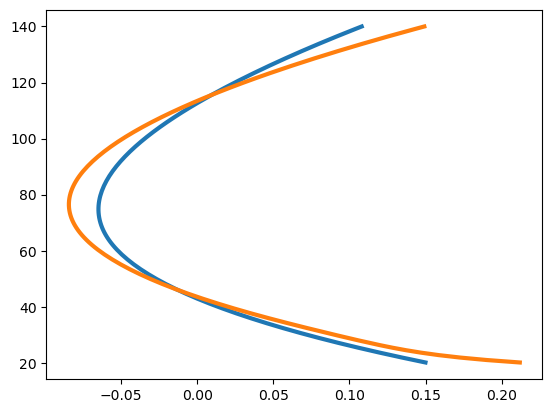

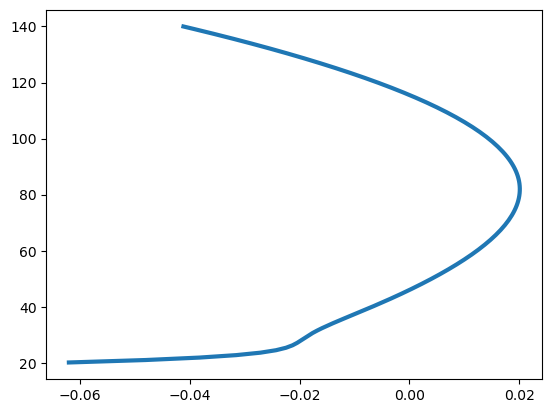

In [71]:
plt.subplots()
plt.plot(detrend(U[:,-1][z>z_min_model]),z[z>z_min_model],'-',linewidth=3)
plt.plot(detrend(U_seasonal[:,-1][z>z_min_model]),z[z>z_min_model],'-',linewidth=3)
plt.show()

plt.subplots()
plt.plot(detrend(U[:,-1][z>z_min_model])-detrend(U_seasonal[:,-1][z>z_min_model]),z[z>z_min_model],'-',linewidth=3)
plt.show()